In [1]:
# model implementation
from ml.models.nn import MLP
from ml.functions.loss import CrossEntropyLoss
from ml.algorithms.optimization import BackpropSGD
from ml.functions.activation import Sigmoid

# model selection
from ml.functions.metrics.classification import MulticlassAccuracy, MulticlassClassificationError

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(25)

## Q1 - Neural Net for classification

### Load dataset

In [2]:
X, y = load_csv('./datasets/vowel.csv')

# one-hot encoding
y = y.astype(int).squeeze()

onehot_dim = (y.shape[0], y.max()+1)
rows = np.arange(y.shape[0])

y_onehot = np.zeros(onehot_dim)
y_onehot[rows, y] = 1

#### Split into train (60%), validation (20%) and test (20%)

In [3]:
X_train, y_train, X_test, y_test = split_train_test(X, y_onehot, 0.6, shuffle=True)
X_train, y_train, X_val, y_val = split_train_test(X_train, y_train, 0.75, shuffle=False)

### Scale data

In [5]:
# scale dataset
x_scaler = MinMaxScaler().fit(X_train)

X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
X_val_scaled = x_scaler.transform(X_val)

### Find best hyperparameters (num neurons and activation function) using grid search

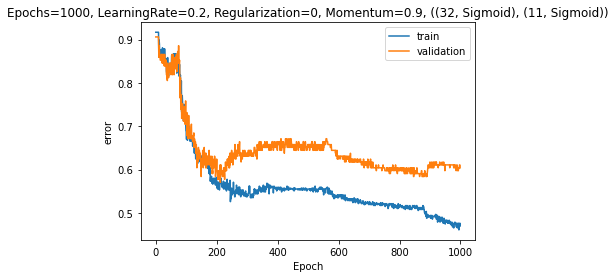

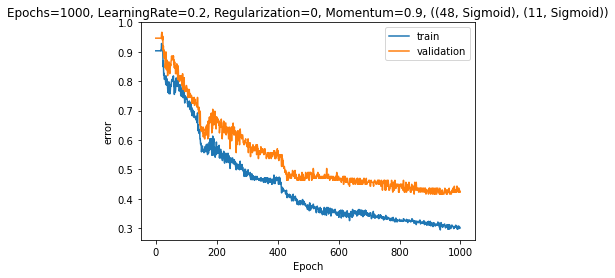

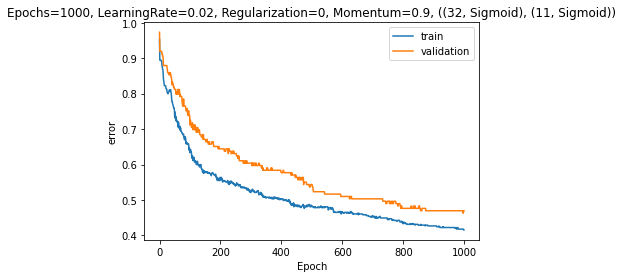

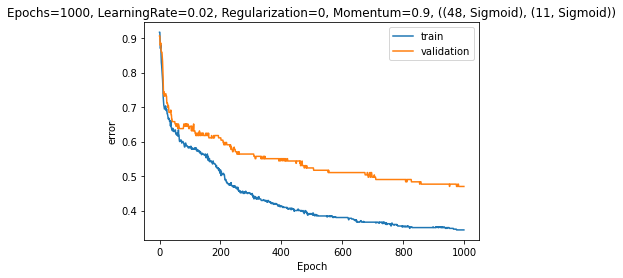

In [6]:
# fixed hyperparams
reg = 0
momentum=0.9

min_val_err = float("inf")

for lr in [0.2, 0.02]:
    for num_neurons in [32, 48]:
        solver = BackpropSGD(epochs=1000,
                    learning_rate=lr,     # <-- hyperparam under test
                    regularization=reg,
                    momentum=momentum,
                    batch_size=32,
                    metrics=MulticlassClassificationError())

        layers = (
            (num_neurons, Sigmoid()),     # <-- hyperparams under test
            (y_onehot.shape[1], Sigmoid()),
        )

        mlp = MLP(layers=layers, solver=solver, loss=CrossEntropyLoss)
        train_err, val_err = mlp.fit(X_train_scaled, y_train, X_val_scaled, y_val)

        plt.plot(train_err, label="train")
        plt.plot(val_err, label="validation")
        plt.title(f"{solver}, {layers}")
        plt.legend()
        plt.ylabel("error")
        plt.xlabel("Epoch")
        plt.show()

        if val_err[-1] < min_val_err:
            best_model = mlp
            min_val_err = val_err[-1]

In [7]:
print("Best hyperparameters for MLP:", best_model.solver, "Layers:", best_model.layers)

Best hyperparameters for MLP: Epochs=1000, LearningRate=0.2, Regularization=0, Momentum=0.9 Layers: ((48, Sigmoid), (11, Sigmoid))


### Train MLP with best hyperparameters

In [8]:
mlp = MLP(layers = best_model.layers, solver=best_model.solver, loss=CrossEntropyLoss)
train_err, test_err = mlp.fit(X_train_scaled, y_train, X_test_scaled, y_test)

### Report train and test errors during training

Text(0.5, 0, 'Epoch')

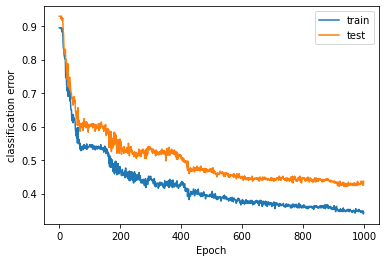

In [9]:
plt.plot(train_err, label="train")
plt.plot(test_err, label="test")
plt.legend()
plt.ylabel("classification error")
plt.xlabel("Epoch")

### Report train and test Accuracy

In [10]:
y_train_pred = mlp.predict(X_train_scaled)
y_val_pred = mlp.predict(X_val_scaled)
y_test_pred = mlp.predict(X_test_scaled)

acc = MulticlassAccuracy()

print("--\nAccuracy(train):", acc.measure(y_train, y_train_pred))
print("--\nAccuracy(validation):", acc.measure(y_val, y_val_pred))
print("--\nAccuracy(test):", acc.measure(y_test, y_test_pred))

--
Accuracy(train): 0.6561797752808989
--
Accuracy(validation): 0.5167785234899329
--
Accuracy(test): 0.5631313131313131
